# Error Exploration
We are not obtaining the desired results, so I am going to look at CELL 0 in the box model to figure out where the coefficients are going wrong. 

In [13]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Open Zarr
ds_zarr = xr.open_zarr('box-example.zarr',
                       consolidated=True,  # http://xarray.pydata.org/en/stable/user-guide/io.html#consolidated-metadata
                      )

## Initial conditions

$\frac{V_0^{0}C_0^{0}}{\Delta t \beta}$, assume an an initial concentration of 1 and $\beta = 1$

In [15]:
init_load = ds_zarr['volume'][0][0] * 1 / (ds_zarr['dt'][0]/ np.timedelta64(1, 's') * 1) 
print(init_load.values)

10.0


## Load at next timestep
$\frac{V_0^{1}C_0^{1}}{\Delta t \beta}$ 

In [16]:
load_coeff = ds_zarr['volume'][1][0] / (ds_zarr['dt'][0]/ np.timedelta64(1, 's') * 1) 
print(load_coeff.values)

13.96484375


## Advection and Dispersion

$\sum_f{\bigl[\frac{A_f \epsilon _f}{\delta_{PN}}(C^{n+1}_N - C^{n+1}_P) - F_fC^{n+1}_f\bigr]}$
* Assume $\epsilon_f$ (dispersion coefficient) is 0.1
* Assume $A_f$ refers to $A_f$ at the $n+1$ timestep?

Faces:
* 4 total 
* Cell 0 touches Cell 1 and Cell 3
* As well as pseudo-cells C9 and C17

In [17]:
f1 = ds_zarr['edge_face_connectivity'].T[0]
f2 = ds_zarr['edge_face_connectivity'].T[1]

print(f1.values)
print(f2.values)

[0 0 0 1 1 1 2 2 4 4 4 5 5 3 3 6 6 7 7 8 0 2 6 8]
[ 3  1  9  2 10  4  5 11  5  3  7  8 12  6 13  7 14 15  8 16 17 18 19 20]


### Diffusion
Errors found:
* Used a method that improperly indexed the faces, which caused some values to be on the wrong face. 

Questions:
* Is there a sign of the $\frac{A_f \epsilon _f}{\delta_{PN}}$ term? based on direction? "Face orientation"?

In [18]:
t = 1

# diffusion
diffusion = ds_zarr['edge_vertical_area'][t]  * 0.1 / ds_zarr['face_to_face_dist']
diffusion.values

array([0.13964869, 0.13964869, 0.27929737, 0.13690821, 0.27381641,
       0.13690821, 0.16318815, 0.19120069, 0.12800928, 0.12800928,
       0.12800928, 0.15210023, 0.17820943, 0.13167749, 0.26335499,
       0.13690434, 0.26996508, 0.16904192, 0.13230803, 0.19867844,
       0.27929737, 0.31959611, 0.17491433, 0.1830569 ])

In [19]:
def sum_vals(face, time_index, sum_array):
    '''
    https://stackoverflow.com/questions/67108215/how-to-get-sum-of-values-in-a-numpy-array-based-on-another-array-with-repetitive
    '''
    nodal_values = np.bincount(face.values, diffusion)
    sum_array[0:len(nodal_values)] = nodal_values
    return sum_array


sum_diffusion_array = np.zeros(len(ds_zarr['nface']))

t = 1

f1_sums = np.zeros(len(ds_zarr['nface'])) 
f2_sums = np.zeros(len(ds_zarr['nface']))

f1_sums = sum_vals(f1, t, f1_sums)
f2_sums = sum_vals(f2, t, f2_sums)

sum_diffusion_array[:] = f1_sums + f2_sums


In [20]:
# confirm they're the same. 
print(sum_diffusion_array[0])
print(diffusion[0].values + diffusion[1].values + diffusion[2].values + diffusion[20].values)

0.8378921127319336
0.8378921127319336


In [21]:
print(diffusion[0].values, diffusion[1].values, diffusion[2].values, diffusion[20].values)

0.13964868545532227 0.13964868545532227 0.27929737091064455 0.27929737091064455


### Advection
$\sum_f{F_fC^{n+1}_f}$

**Upwind differencing** - if $F_f >0$, this indicates that mass is flowing out of the cell; if $F_f < 0$ mass will flow out of the cell. If mass is flowing out of the cell, $C_f$ is $C_0$ (the reference cell), else $C_f$ is $C_N$ (the adjacent cell -- here, either $C_1, C_3, C_9, or C_{17}$ 

The sign is controlled by the velocity. 

Errors:
* `ds_zarr['dt']` was in nanoseconds. 
* should not be multiplying by time! Units are L3/T.


In [22]:
ds_zarr['edge_face_connectivity'][[0,1,2,20]].values

array([[ 0,  3],
       [ 0,  1],
       [ 0,  9],
       [ 0, 17]])

In [23]:
# face normal water flow

edge_normal_water_flow = ds_zarr['edge_vertical_area'][1] * ds_zarr['edge_velocity'][t] * ds_zarr['dt'][0] /np.timedelta64(1, 's')  # L2 * L/T * T = L3
print(edge_normal_water_flow.values[[0,1,2,20]])

[383.84390464 167.78782046   0.           0.        ]


The faces that connect $C_0$ and regular cells ($C_1, C_3$) have a positive face normal water flow, so the advection is OUT.
* Following the upwinds scheme, this means $C_f$ is $C_0$ in all cases.

There is no advection to the two adjacent pseudo cells. 
 


# CELL 1

In [24]:
load_coeff = ds_zarr['volume'][1][3] / (ds_zarr['dt'][0]/ np.timedelta64(1, 's') * 1) 
print(load_coeff.values)


13.167724609375


## No Movement to Boundary Cells
### Velocity

In [33]:
# find edges involving pseudo cell 
f1 = ds_zarr['edge_face_connectivity'].T[0]
f2 = ds_zarr['edge_face_connectivity'].T[1]

f1_pseudo = np.where(f1 > 8)
f2_pseudo = np.where(f2 > 8)

print(f1_pseudo)
print(f2_pseudo)

print(f2[f2_pseudo].values)

(array([], dtype=int64),)
(array([ 2,  4,  7, 12, 14, 16, 17, 19, 20, 21, 22, 23], dtype=int64),)
[ 9 10 11 12 13 14 15 16 17 18 19 20]


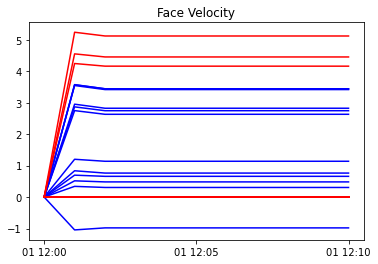

In [48]:
# plot face velocity over time for each cell 
for f in ds_zarr['nedge']:
    # print(ds_zarr['volume'].compute().T.shape)
    if f.values in f2_pseudo[0]:
        color = 'red'
        label = 'pseudo cell'
    else:
        color = 'blue'
        label = 'cell'
    plt.plot(ds_zarr['time'], ds_zarr['edge_velocity'].T[:][f], label=label, color=color)
plt.title('Face Velocity')
plt.show()

### Volume

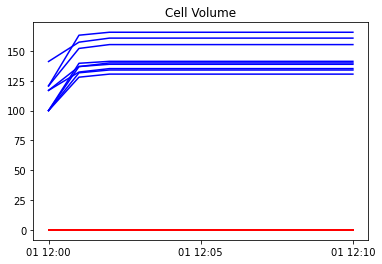

In [49]:
# plot face velocity over time for each cell 
for f in ds_zarr['nface']:
    # print(ds_zarr['volume'].compute().T.shape)
    if f.values > 8:
        color = 'red'
        label = 'pseudo cell'
    else:
        color = 'blue'
        label = 'cell'
    plt.plot(ds_zarr['time'], ds_zarr['volume'].T[:][f], label=label, color=color)
plt.title('Cell Volume')
plt.show()

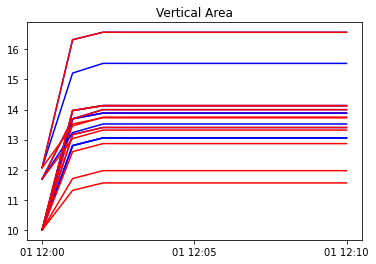

In [52]:
### Vertical Face Area 

# plot face velocity over time for each cell 
for f in ds_zarr['nedge']:
    # print(ds_zarr['volume'].compute().T.shape)
    if f.values in f2_pseudo[0]:
        color = 'red'
        label = 'pseudo cell'
    else:
        color = 'blue'
        label = 'cell'
    plt.plot(ds_zarr['time'], ds_zarr['edge_vertical_area'].T[:][f], label=label, color=color)
plt.title('Vertical Area')
plt.show()